In [1]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=e900f0698071aef45a09df1168bad8659882b4e242fa016a2903d17adb2b22e9
  Stored in directory: /root/.cache/pip/wheels/2e/27/39/f44e52756a6407b444143f233abe9fda0e18a23e8b20e0cd1c
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [3]:
!mkdir datasets

In [4]:
import shutil

In [5]:
source_folder = 'checkpoints'
destination_folder = 'datasets/checkpoints'  # Create 'checkpoints' inside 'datasets'

shutil.move(source_folder, destination_folder)

'datasets/checkpoints'

In [6]:
!kaggle datasets download -d mozillaorg/common-voice -p /content/datasets --force

100% 12.0G/12.0G [02:25<00:00, 32.2MB/s]
100% 12.0G/12.0G [02:25<00:00, 88.8MB/s]


In [7]:
%cd datasets

/content/datasets


In [8]:
!unzip common-voice.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cv-valid-train/cv-valid-train/sample-190776.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190777.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190778.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190779.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190780.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190781.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190782.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190783.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190784.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190785.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190786.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190787.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190788.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190789.mp3  
  inflating: cv-valid-train/cv-valid-train/sample-190790.mp3 

In [9]:
import pandas as pd

In [10]:
dev_df = pd.read_csv('cv-valid-train.csv')
# dev_df.head()

In [11]:
# dev_df.info()

In [12]:
dev_df = dev_df[:4000]

In [13]:
# from IPython.display import Audio, display
# import os

# def display_audio(audio_path):
#   display(Audio(audio_path))

# audio_directory = 'cv-valid-dev/cv-valid-dev'
# audio_files = [audio for audio in os.listdir(audio_directory)]

# for audio_file in audio_files[2000:2050]:
#   audio_path = os.path.join(audio_directory, audio_file)
#   display_audio(audio_path)


In [14]:
# dev_df['down_votes'].value_counts()

In [15]:
# dev_df[dev_df['down_votes'] == 0][:10]

 => It seems that the difference between upvotes and downvotes doesn't relate to the quality of audios

**Preprocessing steps**



In [16]:
dev_df = dev_df.drop(columns=dev_df.columns[dev_df.columns.get_loc('up_votes') : dev_df.columns.get_loc('duration') + 1])

In [17]:
# dev_df.head()

In [18]:
import torch
import os
import torchaudio
import warnings
warnings.filterwarnings('ignore')

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
audio_directory = 'cv-valid-train'

train_size = int(0.8 * len(dev_df))
train_df = dev_df.iloc[:train_size]
test_df = dev_df.iloc[train_size+1:]

train_audio_files = [os.path.join(f) for f in train_df['filename']]
train_texts = train_df['text'].tolist()

test_audio_files = [os.path.join(f) for f in test_df['filename']]
test_texts = test_df['text'].tolist()

In [21]:
# train_df.info()

In [22]:
import re

In [23]:
def clean_text(text):
    # Keep original case - REMOVED .lower()
    text = text.lower().strip()

    # Handle apostrophes/contractions carefully
    text = re.sub(r"([!\#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = re.sub(" +", " ", text)

    return text

In [24]:
from tokenizers import Tokenizer, models, trainers
from tokenizers import pre_tokenizers

In [25]:
# Initialize with byte-level BPE (better for names/contractions)
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))

# Trainer with larger vocab
trainer = trainers.BpeTrainer(
    special_tokens=["<pad>", "<unk>", "<bos>", "<eos>", "<blank>"],
    vocab_size=6000,  # Increased for better word coverage
    min_frequency=3,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet()  # Better for special characters
)

# Train on properly cleaned text
tokenizer.train_from_iterator([clean_text(t) for t in train_texts], trainer)
tokenizer.save("cv_tokenizer.json")

In [26]:
# tokenizer.get_vocab_size()

In [27]:
!pip install noisereduce

In [28]:
import librosa
import soundfile as sf
import noisereduce as nr
from IPython.display import Audio, display
import numpy as np

In [29]:
def remove_silence(audio, sr, top_db=20, frame_length=2048, hop_length=512):
    """Remove silent segments from audio using librosa's trim function"""
    # Trim leading and trailing silence
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=top_db,
                                          frame_length=frame_length,
                                          hop_length=hop_length)
    return trimmed_audio

In [72]:
def preprocess_for_rnnt_torchaudio(file_paths, target_sr=16000, max_duration=5, device='cuda'):
    """GPU-accelerated batch preprocessing pipeline for RNN-T
    Returns:
        log_mel: (batch_size, T, 80) tensor of log Mel spectrograms
        lengths: (batch_size,) tensor of actual lengths in frames
    """
    # Initialize mel transform once
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=400,
        hop_length=160,
        win_length=400,
        n_mels=80,
    ).to(device)

    mel_specs = []
    audio_lengths = []

    # Calculate max_len in frames based on max_duration
    max_len = int(max_duration * target_sr / 160)  # hop_length is 160

    for file_path in file_paths:
        # Load audio with original sample rate
        audio_data, sr = librosa.load(file_path, sr=None)

        # ===== SILENCE REMOVAL =====
        original_duration = len(audio_data) / sr
        audio_data = remove_silence(audio_data, sr)
        new_duration = len(audio_data) / sr
        silence_removed = original_duration - new_duration

        # ===== NOISE REDUCTION =====
        # Only attempt noise reduction if we have enough audio left
        if len(audio_data) > 0.2 * sr:  # At least 200ms remaining
            # Estimate noise from non-silent portions (first 100ms after silence removal)
            noise_samples = int(0.1 * sr)
            noise_profile = audio_data[:min(noise_samples, len(audio_data))]

            reduced_noise = nr.reduce_noise(
                y=audio_data,
                sr=sr,
                y_noise=noise_profile,
                stationary=False,
                prop_decrease=0.8
            )
        else:
            reduced_noise = audio_data  # Skip if too short after silence removal

        # ===== VOLUME NORMALIZATION =====
        rms = np.sqrt(np.mean(reduced_noise**2))
        current_dBFS = 20 * np.log10(max(rms, 1e-10))
        target_dBFS = -20
        gain = min(target_dBFS - current_dBFS, 20)

        if gain > 1:
            amplified_audio = reduced_noise * (10 ** (gain / 20))
            amplified_audio = np.clip(amplified_audio, -1.0, 1.0)
        else:
            amplified_audio = reduced_noise

        # ===== RESAMPLING =====
        target_sr = 16000
        if sr != target_sr:
            resampled_audio = librosa.resample(amplified_audio, orig_sr=sr, target_sr=target_sr)
        else:
            resampled_audio = amplified_audio

        sf.write(file_path, resampled_audio, target_sr, format='mp3')
        audio_tensor, sr = torchaudio.load(file_path)
        audio_tensor = audio_tensor.to(device)
        # 3. Mel transform
        mel_spec = mel_transform(audio_tensor)  # (channels, n_mels, time)
        log_mel = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        log_mel = (log_mel - log_mel.min()) / (log_mel.max() - log_mel.min())
        # Permute to (channels, time, n_mels)
        log_mel = log_mel.permute(0, 2, 1)
        # 4. Padding/trimming
        if log_mel.size(1) > max_len:
            log_mel = log_mel[:, :max_len+1, :]
        else:
            pad_amount = max_len + 1 - log_mel.size(1)
            log_mel = torch.nn.functional.pad(log_mel, (0, 0, 0, pad_amount))

        mel_specs.append(log_mel.squeeze(0))  # Remove channel dimension if single channel
        audio_lengths.append(log_mel.size(1))

    # Stack into batch (batch_size, T, n_mels)
    mel_specs = torch.stack(mel_specs)
    audio_lengths = torch.tensor(audio_lengths, dtype=torch.int32)

    return mel_specs, audio_lengths

In [58]:
import matplotlib.pyplot as plt

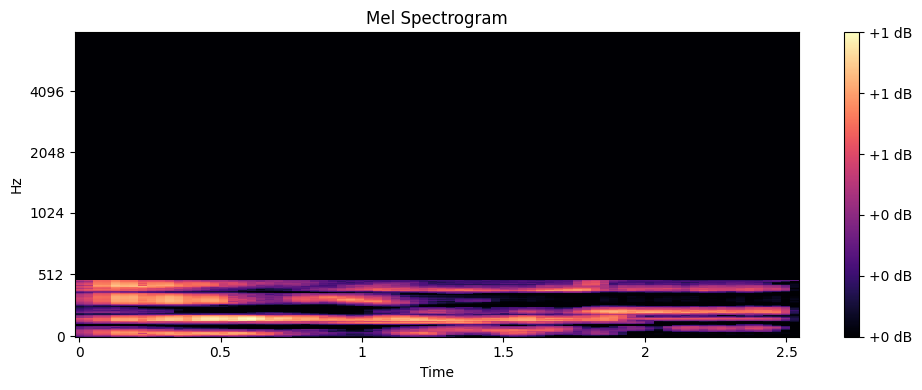

In [74]:
log_mel, audio_lengths = preprocess_for_rnnt_torchaudio(['cv-valid-test/cv-valid-test/sample-000001.mp3'], device=device)
plt.figure(figsize=(10, 4))
# Convert the PyTorch tensor to a NumPy array
librosa.display.specshow(
    log_mel.cpu().numpy()[0], # Access the first element if it's a batch of size 1
    sr=16000,
    x_axis='time',
    y_axis='mel',
    fmax=8000,
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [31]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, num_layers=3):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        self.linear = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        # x: (B, T, input_dim)
        x, _ = self.lstm(x)  # (B, T, 2*H)
        x = self.dropout(x)
        x = self.linear(x)   # (B, T, H)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embed = torch.nn.Embedding(vocab_size, embed_dim)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, y):
        # y: (B, U)
        y = self.embed(y)     # (B, U, E)
        y, _ = self.lstm(y)   # (B, U, H)
        y = self.dropout(y)
        return y

class JointNetwork(torch.nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        # Use a more robust approach with a multi-layer network
        self.joint = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, vocab_size)
        )

    def forward(self, h_enc, h_dec):
        # h_enc: (B, T, H), h_dec: (B, U, H)

        # Get batch size and sequence lengths
        batch_size = h_enc.size(0)
        T = h_enc.size(1)  # Audio sequence length
        U = h_dec.size(1)  # Text sequence length

        # Expand dimensions for broadcasting
        h_enc = h_enc.unsqueeze(2)  # (B, T, 1, H)
        h_dec = h_dec.unsqueeze(1)  # (B, 1, U, H)

        # Expand to create the full cartesian product for alignment
        h_enc = h_enc.expand(-1, -1, U, -1)  # (B, T, U, H)
        h_dec = h_dec.expand(-1, T, -1, -1)  # (B, T, U, H)

        # Concatenate features
        joint = torch.cat([h_enc, h_dec], dim=-1)  # (B, T, U, 2H)

        # Apply joint network to get logits
        logits = self.joint(joint)  # (B, T, U, V)

        return logits

class RNNTransducer(torch.nn.Module):
    def __init__(self, vocab_size, encoder_dim=256, decoder_dim=256):
        super().__init__()
        self.encoder = Encoder(hidden_dim=encoder_dim)
        self.decoder = Decoder(vocab_size, hidden_dim=decoder_dim)
        self.joint = JointNetwork(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, x, y):
        # x: (B, T, features), y: (B, U)
        h_enc = self.encoder(x)  # (B, T, H)
        h_dec = self.decoder(y)  # (B, U, H)

        # Both should now have the same hidden dimension
        logits = self.joint(h_enc, h_dec)  # (B, T, U, V)
        return logits



# First, let's prepare the dataset class
class AudioTextDataset(torch.utils.data.Dataset):
    def __init__(self, audio_files, texts, tokenizer, max_text_length=100,
                 target_sr=16000, max_duration=5):
        """
        Dataset class that handles:
        - File paths for batch audio processing
        - Text sequences with tokenization
        - Automatic audio preprocessing in batches
        """
        self.audio_files = [str(f) for f in audio_files]  # Ensure string paths
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length
        self.target_sr = target_sr
        self.max_duration = max_duration

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Returns single item with:
        - audio_file: Path for batch processing
        - text: Raw text string for tokenization in collate
        """
        return {
            'audio_file': self.audio_files[idx],
            'text': self.texts[idx],
            'tokenizer': self.tokenizer,  # Pass tokenizer for collate_fn
            'max_text_length': self.max_text_length
        }

def collate_fn(batch, device='cuda'):
    """
    Custom collate function that:
    1. Processes audio files in batch using preprocess_for_rnnt_torchaudio
    2. Tokenizes and pads text sequences
    3. Handles audio length preservation
    """
    # Extract batch components
    audio_files = [item['audio_file'] for item in batch]
    texts = [item['text'] for item in batch]

    # Batch process audio files
    audio_features, audio_lengths = preprocess_for_rnnt_torchaudio(
        audio_files,
        target_sr=batch[0].get('target_sr', 16000),
        max_duration=batch[0].get('max_duration', 5),
        device=device
    )  # (B, T, 80)

    target_lengths = [item['max_text_length'] - 2 for item in batch]

    # Tokenize and pad texts
    text_sequences = []
    for item in batch:
        encoding = item['tokenizer'].encode(item['text'])
        text_ids = encoding.ids

        # Add special tokens
        text_ids = [
            item['tokenizer'].token_to_id("<bos>")
        ] + text_ids + [
            item['tokenizer'].token_to_id("<eos>")
        ]

        # Pad or truncate
        max_len = item['max_text_length']
        if len(text_ids) < max_len:
            text_ids = text_ids + [item['tokenizer'].token_to_id("<pad>")] * (max_len - len(text_ids))
        else:
            text_ids = text_ids[:max_len]

        text_sequences.append(torch.tensor(text_ids, dtype=torch.int32))

    target_lengths_tensor = torch.tensor(target_lengths, dtype=torch.int32)
    # Stack text sequences
    text_tensor = torch.stack(text_sequences)

    return {
        'audio': audio_features.to(device),  # (B, T, 80)
        'text': text_tensor.to(device),     # (B, U_max)
        'target_lengths': target_lengths_tensor.to(device),
        'audio_lengths': torch.tensor(audio_lengths, device=device) # (B,)
    }

In [32]:
def train_epoch(model, dataloader, optimizer, scheduler, device, tokenizer, mixed_precision=True):
    model.train()
    total_loss = 0
    steps = 0

    # Enable mixed precision for faster training and lower memory usage
    scaler = torch.cuda.amp.GradScaler() if mixed_precision else None

    for batch_idx, batch in enumerate(dataloader):
        # Get batch data
        audio = batch['audio']  # (B, T, 80)
        text = batch['text']    # (B, U)

        # Get lengths
        input_lengths = batch['audio_lengths']
        target_lengths = batch['target_lengths']

        # Clear gradients
        optimizer.zero_grad()

        if mixed_precision:
            with torch.cuda.amp.autocast():
                # Forward pass - encoder
                encoder_output = model.encoder(audio)

                # Forward pass - decoder and joint
                h_dec = model.decoder(text[:, :-1])  # (B, U-1, H)
                logits = model.joint(encoder_output, h_dec)  # (B, T, U-1, V)

                # For targets, use labels shifted right (exclude BOS)
                targets = text[:, 1:-1].contiguous()  # Remove only BOS for targets

                # Compute loss
                blank_id = tokenizer.token_to_id('<blank>')
                loss = torchaudio.functional.rnnt_loss(
                    logits=torch.nn.functional.log_softmax(logits, dim=-1),
                    targets=targets,
                    logit_lengths=input_lengths,
                    target_lengths=target_lengths,
                    blank=blank_id,
                    reduction='mean'
                )

            # Backward pass with scaled gradients
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Lower clip threshold
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training without mixed precision
            encoder_output = model.encoder(audio)
            h_dec = model.decoder(text[:, :-1])
            logits = model.joint(encoder_output, h_dec)

            targets = text[:, 1:-1].contiguous()

            blank_id = tokenizer.token_to_id('<blank>')
            loss = torchaudio.functional.rnnt_loss(
                logits=torch.nn.functional.log_softmax(logits, dim=-1),
                targets=targets,
                logit_lengths=input_lengths,
                target_lengths=target_lengths,
                blank=blank_id,
                reduction='mean'
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Update learning rate with scheduler
        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()
        steps += 1

    return total_loss / steps

In [33]:
tokenizer = Tokenizer.from_file("cv_tokenizer.json")

In [34]:
# Create datasets
train_dataset = AudioTextDataset(
    audio_files=[os.path.join(audio_directory, f) for f in train_audio_files],
    texts=train_texts,
    tokenizer=tokenizer,
)

In [35]:
test_dataset = AudioTextDataset(
    audio_files=[os.path.join(audio_directory, f) for f in test_audio_files],
    texts=test_texts,
    tokenizer=tokenizer,
)

In [36]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, device=device)
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda batch: collate_fn(batch, device=device)
)

In [37]:
checkpoint_path = 'checkpoints/rnnt_epoch_41.pt'
checkpoint = torch.load(checkpoint_path)

In [38]:
# Initialize model
model = RNNTransducer(vocab_size=tokenizer.get_vocab_size()).to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=1e-5,
    betas=(0.9, 0.999)
)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # Monitor training loss
    factor=0.5,  # Reduce LR by half when loss plateaus
    patience=2,  # Number of epochs with no improvement before reducing LR
    verbose=True  # Print updates when LR changes
)
save_dir = 'checkpoints'

# Training loop
for epoch in range(50):
    # Train for one epoch
    train_loss = train_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        scheduler=None,
        device=device,
        tokenizer=tokenizer,
        mixed_precision=True
    )

    print(f"Train Loss {epoch}: {train_loss:.4f}")

    scheduler.step(train_loss)
    # Save checkpoint
    if save_dir: # Use save_dir instead of args.save_dir
        os.makedirs(save_dir, exist_ok=True)
        checkpoint_path = os.path.join(save_dir, f"rnnt_epoch_{epoch+42}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)
        print(f"Saved checkpoint to {checkpoint_path}")

print("Training complete!")

Train Loss 0: 12.1465
Saved checkpoint to checkpoints/rnnt_epoch_42.pt


KeyboardInterrupt: 

In [ ]:
from typing import List, Union

In [ ]:
def predict_rnnt_beam_search(
    model: torch.nn.Module,
    audio_features: torch.Tensor,
    tokenizer: object,
    device: Union[str, torch.device],
    beam_width: int = 5,
    max_decode_len: int = 100,
) -> str:
    """
    Performs beam search decoding for an RNN-T model.

    Args:
        model: The RNN-T model
        audio_features: The audio features tensor
        tokenizer: The tokenizer object
        device: The device to run inference on
        beam_width: Width of the beam search
        max_decode_len: Maximum decoding length

    Returns:
        The best decoded transcript
    """
    # Add batch dimension if missing (shape: [1, T, D])
    if len(audio_features.shape) == 2:
        audio_features = audio_features.unsqueeze(0).to(device)
    else:
        audio_features = audio_features.to(device)

    with torch.no_grad():
        # Encode the audio features
        h_enc = model.encoder(audio_features)  # [1, T, H]

        # Initialize the beam
        # Each beam element: (negative log prob, sequence, decoder state)
        bos_token = tokenizer.token_to_id("<bos>")
        eos_token = tokenizer.token_to_id("<eos>")
        blank_token = tokenizer.token_to_id("<blank>")

        # Initialize beam with just the beginning token
        current_idx = torch.tensor([[bos_token]], device=device)
        initial_decoder_output = model.decoder(current_idx)  # [1, 1, H]

        # Start with a single beam
        beams = [(0.0, [bos_token], initial_decoder_output)]
        finished_beams = []

        # Main beam search loop
        for step in range(max_decode_len):
            candidates = []

            # Expand each current beam
            for log_prob, sequence, decoder_output in beams:
                # Skip if sequence already ended
                if sequence[-1] == eos_token:
                    finished_beams.append((log_prob, sequence))
                    continue

                # Run joint network on the encoded audio and last decoder output
                logits = model.joint(h_enc, decoder_output)  # [1, T, 1, V]

                # Sum over time dimension for alignment scores
                log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
                scores = log_probs.sum(dim=1).squeeze(1)  # [1, V]

                # Get top-k tokens
                top_log_probs, top_indices = scores.topk(beam_width)

                # Add candidates to our list
                for i in range(beam_width):
                    token_id = top_indices[0, i].item()
                    token_log_prob = top_log_probs[0, i].item()

                    # Skip blank tokens in final output but consider them for alignment
                    if token_id == blank_token:
                        candidates.append((log_prob + token_log_prob, sequence.copy(), decoder_output))
                    else:
                        new_sequence = sequence.copy() + [token_id]

                        # Update decoder state with new token
                        new_token = torch.tensor([[token_id]], device=device)
                        new_decoder_output = model.decoder(new_token)

                        candidates.append((log_prob + token_log_prob, new_sequence, new_decoder_output))

            # Keep only the best beam_width candidates
            candidates.sort(key=lambda x: x[0], reverse=True)  # Sort by log probability (higher is better)
            beams = candidates[:beam_width]

            # Early stopping if all beams have finished
            if all(beam[1][-1] == eos_token for beam in beams):
                break

        # Add any unfinished beams to finished_beams
        for log_prob, sequence, _ in beams:
            if sequence[-1] != eos_token:
                finished_beams.append((log_prob, sequence))

        best_sequence = None
        # print("Number of beams: ", finished_beams)
        # Select the most likely beam
        if finished_beams:
            best_beam = max(finished_beams, key=lambda x: x[0])
            best_sequence = best_beam[1]
        else:
            best_sequence = beams[0][1]  # Best unfinished beam

        # Remove special tokens (BOS, EOS) for the final output
        filtered_sequence = [token for token in best_sequence
                            if token != bos_token and token != eos_token]

        return tokenizer.decode(filtered_sequence)

In [ ]:
import os
import torch

# Specify the directory where checkpoints are saved
save_dir = 'checkpoints'

# Get the last checkpoint file
last_checkpoint_file = 'rnnt_epoch_41.pt'

# Load the checkpoint
checkpoint_path = os.path.join(save_dir, last_checkpoint_file)
checkpoint = torch.load(checkpoint_path)

# Create a new instance of your model (if needed)
model = RNNTransducer(vocab_size=tokenizer.get_vocab_size()).to(device)

# Load the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state dictionary (optional)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode

print(f"Loaded checkpoint from {checkpoint_path}")
print(f"Loss: {checkpoint['loss']}")

In [ ]:
!pip install jiwer

In [ ]:
import jiwer

In [ ]:
# Load model, tokenizer, and features
model.eval()  # Your RNN-T model  # Shape: [T, D]
i = 0
with torch.no_grad():
    for audio in test_audio_files[0:10]:
        audio_features, _ = preprocess_for_rnnt_torchaudio([os.path.join(audio_directory, audio)])
        text_beam = predict_rnnt_beam_search(model, audio_features, tokenizer, "cuda")
        wer = jiwer.wer(test_texts[i], text_beam)
        print(f"Beam: {text_beam}")
        print(f"Real text: {test_texts[i]}")
        print(f"wer: {wer:.4f}")
        i += 1

In [ ]:
!zip -r checkpoints.zip checkpoints

In [ ]:
from google.colab import files
files.download('checkpoints.zip')